In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import numpy as np
import pandas as pd

In [2]:
class MCQ_recap():
    
    def __init__(self):
        # Filepath to Excel raw file
        self.origin_file = "./raw/MCQ_B.xlsx"
        
        # Filepath to Excel treated file
        self.target_file = "./treated/MCQ_B.xlsx"
        
        # Start_time
        self.start_time = "13:05:00"
        
        # Raw Data
        self.raw_data = None
        self.get_raw_data()
        
        # Treated Data
        self.treated_data = None
        
        # Question list
        self.questions_list = []
        self.create_questions_list()
        
        # All submissions list
        self.all_subs_list = []
        self.extract_all_subs()
        self.compute_grades_all_subs()
        
        # Grades_list
        self.grades_list = []
        self.remove_duplicates()
        
        # Save to file
        self.recreate_pd_data()
        self.save_to_excel()
        
        # Get data metrics
        self.get_data_metrics()
        
        
    def create_questions_list(self):
        
        # List of answers
        answers = ["4", \
                   ["6", "6.0"], \
                   ["8", "8.0"], \
                   "10", \
                   "The triple of 3 is 333.", \
                   "1", \
                   "Hello, followed by Bonjour", \
                   "False", \
                   "4", \
                   "None of the above", \
                   "19", \
                   "33", \
                   "An error message", \
                   "20", \
                   "We have an infinite while loop, the program will keep on printing values undefinitely.", \
                   "11", \
                   "18", \
                   "22", \
                   "-2", \
                   "[::-2]", \
                   "[1,2,3,4,6]", \
                   "grades[2][3]", \
                   "20", \
                   ["990", "990.0"], \
                   "No values will be printed."]
        
        # Generate questions_list
        self.questions_list = [MCQ_question(index + 1, 4, answer) for index, answer in enumerate(answers)]
        
        # Override question 11
        self.questions_list[10].override = True
        
        
    def get_raw_data(self):
        
        # Read raw data from file
        self.raw_data = pd.read_excel(self.origin_file).astype(str).to_numpy()
        
    
    def extract_all_subs(self):
        
        for submission in self.raw_data:
            self.all_subs_list.append(MCQ_submission(submission))
            
    
    def get_elapsed_time(self, sub_time):
        
        hour_start = int(self.start_time.split(":")[0])
        minutes_start = int(self.start_time.split(":")[1])
        sub_time_hours = int(sub_time.split(":")[0])
        sub_time_minutes = int(sub_time.split(":")[1])
        total_minutes = (sub_time_hours - hour_start)*60 + (sub_time_minutes - minutes_start)
        #self.elapsed_time = "{}:{}".format(total_minutes//60, total_minutes%60)
        elapsed_time = total_minutes
        return elapsed_time
        
    
    def compute_grades_all_subs(self):
        
        for submission in self.all_subs_list:
            for student_answer, question in zip(submission.answers_list, self.questions_list):
                grade = question.grade(student_answer[1])
                submission.scores_list.append(grade)
                submission.total_grade += grade
                submission.elapsed_time = self.get_elapsed_time(submission.timestamp)
                
                
    def remove_duplicates(self):
        
        for index, submission in enumerate(self.all_subs_list):
            list_of_ID_rest = [sub.ID for sub in self.all_subs_list[index + 1:]]
            if(submission.ID) not in list_of_ID_rest:
                self.grades_list.append(submission)
                
                
    def get_data_metrics(self):
        
        # Compute average score and std
        grades = [grade.total_grade for grade in self.grades_list]
        avg = round(np.mean(grades), 1)
        var = round(np.std(grades), 1)
        print("Average MCQ score: {}% +/- {}%".format(avg, var))
        
        # Histogram of grades
        plt.figure()
        plt.hist(grades, bins = 20)
        plt.xlabel("Grade")
        plt.ylabel("Number of students")
        plt.title("MCQ grades distribution")
        plt.show()
        
        # Compute average score and std
        times = [grade.elapsed_time for grade in self.grades_list]
        avg = round(np.mean(times), 1)
        var = round(np.std(times), 1)
        print("Average MCQ time to submit: {} minutes +/- {} minutes.".format(avg, var))
        
        # Histogram of time to submit
        plt.figure()
        plt.hist(times, bins = 20)
        plt.xlabel("Time to submit (minutes)")
        plt.ylabel("Number of students")
        plt.title("Time to submit (minutes) distribution")
        plt.show()
        
        # Error rate per question
        total_points = 4*self.treated_data.shape[0]
        total_score_per_q = [round(self.treated_data["Q{}".format(index + 1)].sum()/total_points*100, 1) \
                             for index in range(25)]
        
        # Histogram of time to submit
        plt.figure()
        plt.bar(list(range(1, 26)), total_score_per_q)
        plt.xlabel("Question")
        plt.ylabel("Percentage of correct answers")
        plt.title("Percentage of correct answers per question")
        xticks(list(range(1, 26)), list(range(1, 26)))
        plt.show()
        
    
    def recreate_pd_data(self):
        
        # Initialize dictionary
        data_dic = {"Name": [], "ID": [], "Time to submit": []}
        data_dic.update({"Q{}".format(i+1): [] for i in range(25)})
        data_dic.update({"Total MCQ score": []})
        
        # Add entries
        for submission in self.grades_list:
            data_dic["Name"].append(submission.name)
            data_dic["ID"].append(submission.ID)
            data_dic["Time to submit"].append(submission.elapsed_time)
            for index, score in enumerate(submission.scores_list):
                data_dic["Q{}".format(index + 1)].append(score)
            data_dic["Total MCQ score"].append(submission.total_grade)
        
        # To pandas
        self.treated_data = pd.DataFrame(data_dic)
        
    
    def save_to_excel(self):
        
        self.treated_data.to_excel(self.target_file, engine = "xlsxwriter")

In [3]:
class MCQ_question():
    
    def __init__(self, number, points, correct_answer, override = False):
        # Question number
        self.number = number
        
        # Number of points
        self.points = points
        
        # Correct answer
        self.correct_answer = correct_answer
        
        # Override
        self.override = override
    
    
    def grade(self, student_answer):
        
        if self.override:
            # Override question
            return self.points
        elif(isinstance(self.correct_answer, list)):
            return self.points*int(student_answer in self.correct_answer)
        else:
            # Check for correct answer
            return self.points*int(self.correct_answer == student_answer)

In [4]:
class MCQ_submission():
    
    def __init__(self, student_sub):
        
        # Student name
        self.name = None
        self.get_name(student_sub)
        
        # Student ID
        self.ID = None
        self.get_ID(student_sub)
        
        # Timestamp
        self.timestamp = None
        self.convert_timestamp(student_sub)
        
        # Elapsed time
        self.elapsed_time = None
        
        # Answers_list
        self.answers_list = []
        self.get_answers_list(student_sub)
        
        # Scores list
        self.scores_list = []
        
        # Total grade
        self.total_grade = 0
        
        
    def get_name(self, student_sub):
        
        self.name = student_sub[1]
        
        
    def get_ID(self, student_sub):
        
        self.ID = student_sub[2]
        
        
    def convert_timestamp(self, student_sub):
        
        self.timestamp = student_sub[0][-12:-4]
        
        
    def get_answers_list(self, student_sub):
        
        self.answers_list = []
        for index, answer in enumerate(student_sub[3:]):
            self.answers_list.append((index + 1, answer))

Average MCQ score: 82.9% +/- 15.6%


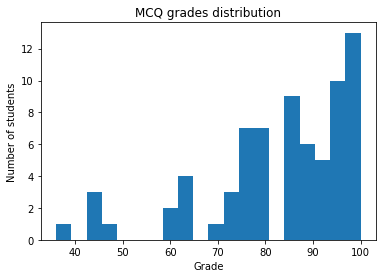

Average MCQ time to submit: 35.9 minutes +/- 8.5 minutes.


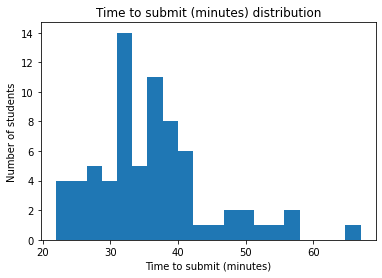

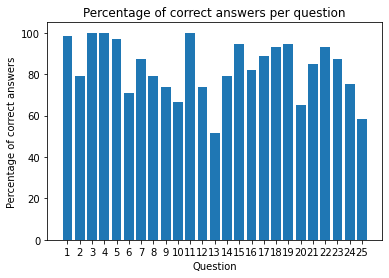

In [5]:
r = MCQ_recap()